# NB00: Constraining the ZAMS parameters of CHE binaries with MS winds

The $35\,\mathrm{M}_\odot$ bump in the BBH merger $m_1$ ($M$) distribution has been found to be a well-defined feature. This implies that any channel responsible for producing it should have some particular turn-on/turn-off mechanism that leads to the production of a bump feature, as opposed to, e.g., a step (sharp turn-on, then slowly decaying tail). For the CHE channel specifically, it's easy to imagine that a smooth turn-on is related to the increasing efficiency of chemical mixing with mass, which makes for increasingly radiative stars; a sharp turn-on might be related to coalescence times, which could be too long for less massive CHE binaries. This does not explain a turn-off, however. A few ideas for turn-off mechanisms are,

* Winds: winds are increasingly efficient at removing mass and angular momentum with increasing mass, which widens the binary. Because close orbits are necessary to tidally lock the star into a high enough rotation rate for chemical mixing to be efficient, winds could then act to remove the most massive binaries from the CHE track during MS.
* Radii: requiring no RLOF/L2OF at ZAMS imposes a minimum orbital period that is increasing with mass and metallicity. As radii increase with mass, this minimum orbital period might eventually be too long to allow for CHE.
* ZAMS orbital period distr.: if massive primaries are increasingly shifted towards very short orbits due to preferential formation from disk fragmentation, the CHE window might simply not be well-populated for the highest masses; instead, very massive binaries would be lost to ZAMS RLOF or L2OF. Even if CHE were capable of forming $>>35\,\mathrm{M}_\odot$ binaries, no/very few binaries would be formed that followed that channel.

None of these possibilities are mutually exclusive. Here we collect some of these constraints, and check if they define a closed window for CHE evolution in the ZAMS parameter space (mostly in terms of $M$ and $P$).

## Imports & utilities

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import astropy.units as u
import astropy.constants as ct
from scipy.optimize import fmin
from scipy.interpolate import CubicSpline
from astropy.cosmology import WMAP9

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

In [3]:
plt.style.use('./plotstyle.mplstyle')

In [4]:
MASS_U = u.M_sun
PERIOD_U = u.day
AGE_U = u.Myr
SMA_U = u.R_sun
RADIUS_U = u.R_sun
TEMP_U = u.kK

Z_SUN = 0.02
t_H = WMAP9.age(0).to(AGE_U)

In [5]:
Z_SUN = 0.02

In [6]:
def fix_unit(var, unit):
    """If a variable is passed without a unit, set it to a specified one."""
    if type(var) != u.quantity.Quantity:
        var *= unit
    else:
        pass
    return var

In [7]:
def p_from_a(a, m, q):
    a = fix_unit(a, SMA_U)
    m = fix_unit(m, MASS_U)
    p = np.sqrt(4 * np.pi**2 / (ct.G * (1+q) * m) * a**3)
    p = p.to(PERIOD_U)
    return p

In [8]:
def a_from_p(p, m, q):
    p = fix_unit(p, PERIOD_U)
    m = fix_unit(m, MASS_U)
    a = np.cbrt(ct.G * (1+q) * m / (4*np.pi**2) * p**2)
    a = a.to(SMA_U)
    return a

## References

Eggleton, P. P., *Aproximations to the radii of Roche lobes*, 1983, [ApJ, 268, 368](https://ui.adsabs.harvard.edu/abs/1983ApJ...268..368E/abstract).  
Gormaz-Matamala, A. C., Curé, M., Meynet, G., Cuadra, J., Groh, J. H. & Murphy, L. J., *Evolution of massive stars with new hydrodynamic wind models*, 2022, [A&A, 665, 15](https://ui.adsabs.harvard.edu/abs/2022A%26A...665A.133G/abstract).  
Maeder, A., *Physics, Formation and Evolution of Rotating Stars*, Springer (Heidelberg, 2009).  
Marchant, P., Langer, N., Podsiadlowski, P., Tauris, T. M. & Moriya, T. J., *A new route towards merging massive black holes*, 2016, [A&A, 588, 13](https://ui.adsabs.harvard.edu/abs/2016A%26A...588A..50M/abstract).  
Pols, O., *Compact binaries lecture notes, part II*, at https://www.astro.ru.nl/~onnop/education/binaries_utrecht_notes/   
Romagnolo, A., Gormaz-Matamala, A. C. & Belczynski, K., *On the Maximum Black Hole Mass at Solar Metallicity*, 2024, [ApJL, 964, 8](https://ui.adsabs.harvard.edu/abs/2024ApJ...964L..23R/abstract).  
Tout, C. A., Pols, O. R., Eggleton, P. R. & Han, Z., *Zero-age main-sequence radii and luminosities as analytic functions of mass and metallicity*, 1996, [MNRAS, 281, 257](https://ui.adsabs.harvard.edu/abs/1996MNRAS.281..257T/abstract).

## Quantity definitions

### Stellar parameters

We start by defining the basic, mass- and (in some cases) metallicity-dependent, stellar parameters: radius, luminosity, effective temperature and surface gravity.

Metallicity-dependent mass-radius and mass-luminosity relations (MRR and MLR) are taken from Tout et al. (1996). For the MRR,

$$
R(M,Z) = \frac  {\theta M^{2.5} + \iota M^{6.5} + \kappa M^{11} + \lambda M^{19} + \mu M^{19.5}}
                {\nu + \xi M^{2} + \omicron M^{8.5} + M^{18.5} + \pi M^{19.5}},
$$

where each parameter is given by a set of $a,b,c,d,e$ coefficients, as

$$\theta = a + b\log Z/\mathrm{Z}_\odot + c \log^2 Z/\mathrm{Z}_\odot + d \log^3 Z/\mathrm{Z}_\odot + e \log^4 Z/\mathrm{Z}_\odot,$$

The table with all coefficients is stored in ```tout_zams_mrr```. The class below loads it, computes the  coefficients for a given metallicity, and allows getting the radius for any mass.

In [9]:
class ToutMassRadiusRelation:
    """Mass-radius relation at ZAMS from Tout et al. (1996)."""

    def __init__(self, metallicity=Z_SUN):
        self.metallicity = metallicity
        self.fit_params = None
        self.coefficients = None
        self._load_fit_params()
        self._set_coefficients()

    def _load_fit_params(self):
        self.fit_params = np.genfromtxt('tout_zams_mrr', skip_header=True, usecols=(1, 2, 3, 4, 5))
    
    def _set_coefficients(self):
        met_factor = np.array([np.log10(self.metallicity/Z_SUN)**i for i in range(5)])
        met_factor = np.tile(met_factor, (10, 1))
        met_factor[-2] = np.ones(5)/5
        self.coefficients = self.fit_params * met_factor
        self.coefficients = np.sum(self.coefficients, axis=1)

    def radius(self, m):
        m = fix_unit(m, MASS_U).to(u.Msun).value
        indices = np.array([2.5, 6.5, 11, 19, 19.5, 0, 2, 8.5, 18.5, 19.5])
        terms = self.coefficients * m**indices
        radius = np.sum(terms[:5]) / np.sum(terms[5:])
        return radius * u.Rsun
        

In [10]:
test_masses = np.logspace(-1, 2.5, 30)

mrr_z006 = ToutMassRadiusRelation(metallicity=0.06)
test_radii_z006 = np.array([mrr_z006.radius(m).value for m in test_masses])

mrr_z002 = ToutMassRadiusRelation(metallicity=0.02)
test_radii_z002 = np.array([mrr_z002.radius(m).value for m in test_masses])

mrr_z0002 = ToutMassRadiusRelation(metallicity=0.002)
test_radii_z0002 = np.array([mrr_z0002.radius(m).value for m in test_masses])

mrr_z00002 = ToutMassRadiusRelation(metallicity=0.0002)
test_radii_z00002 = np.array([mrr_z00002.radius(m).value for m in test_masses])

Text(0.5, 1.0, 'ZAMS mass-radius relation from Tout et al. (1996)')

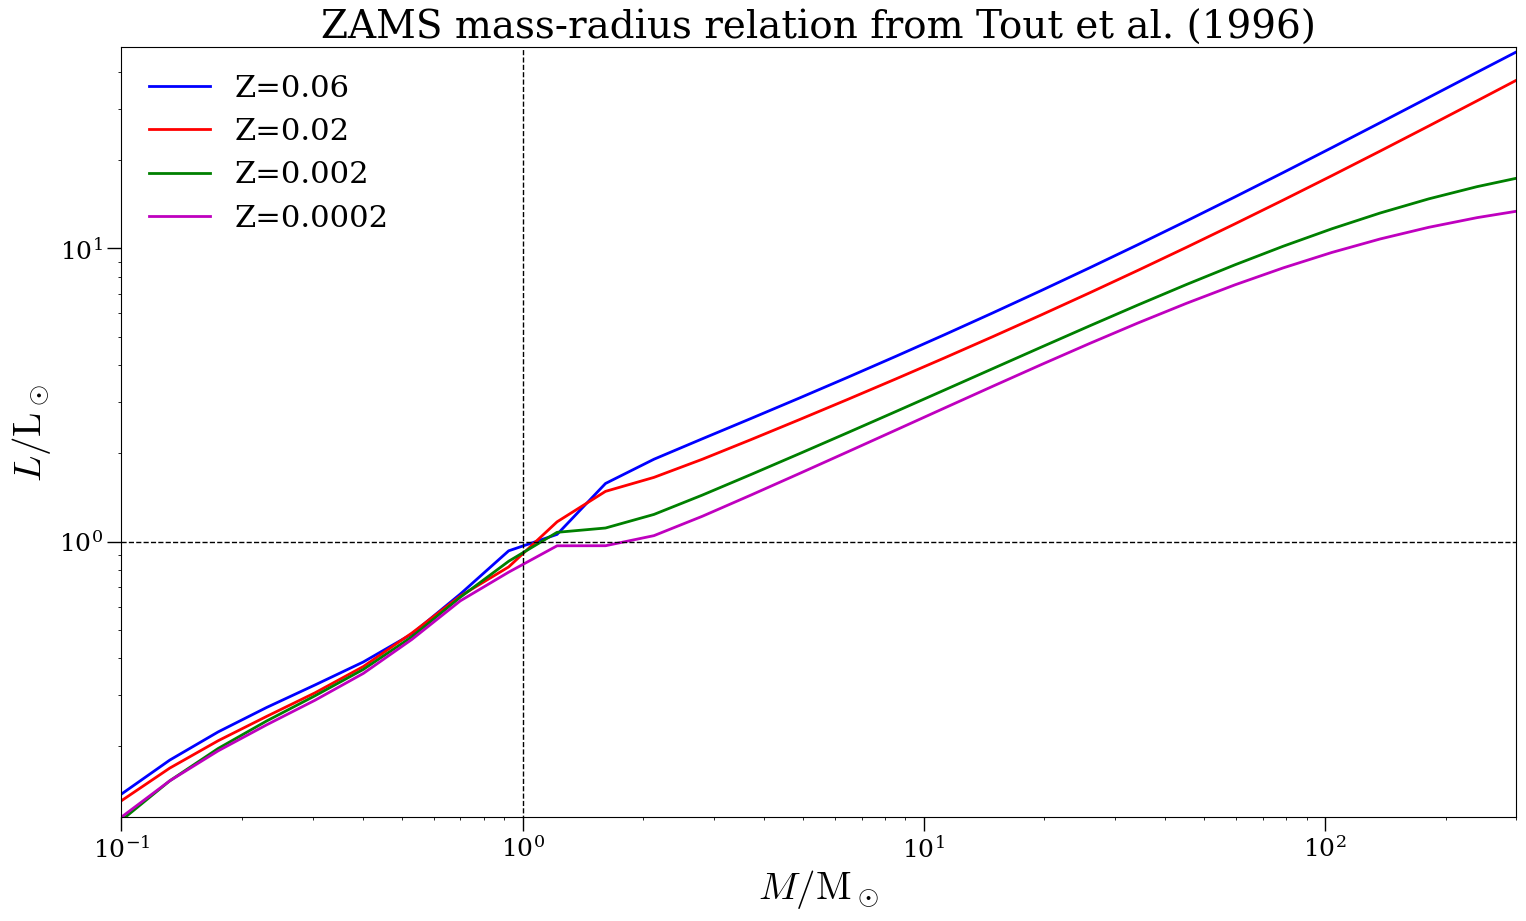

In [11]:
fig, ax = plt.subplots(figsize=(18,10))

ax.plot(test_masses, test_radii_z006, 'b', label='Z=0.06')
ax.plot(test_masses, test_radii_z002, 'r', label='Z=0.02')
ax.plot(test_masses, test_radii_z0002, 'g', label='Z=0.002')
ax.plot(test_masses, test_radii_z00002, 'm', label='Z=0.0002')
ax.set_xscale('log')
ax.set_yscale('log')
ax.vlines(1, 0.1, 100, color='k', ls='--', lw=1)
ax.hlines(1, 0.1, 300, color='k', ls='--', lw=1)
ax.set_ylim(min(test_radii_z00002), max(test_radii_z006))
ax.set_xlim(0.1, 300)

ax.legend(frameon=False)
ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
ax.set_ylabel('$L/\\mathrm{L}_\\odot$')

ax.set_title('ZAMS mass-radius relation from Tout et al. (1996)')

For the MLR,

$$
R(M,Z) = \frac  {\alpha M^{5.5} + \beta M^{11}}
                {\gamma + M^3 + \delta M^5 + \epsilon M^7 + \zeta M^8 + \eta M^{9.5}},
$$

where each parameter given as before, as

$$\theta = a + b\log Z/\mathrm{Z}_\odot + c \log^2 Z/\mathrm{Z}_\odot + d \log^3 Z/\mathrm{Z}_\odot + e \log^4 Z/\mathrm{Z}_\odot,$$

The table with all coefficients is stored in ```tout_zams_mlr```. The class below loads it, computes the  coefficients for a given metallicity, and allows getting the radius for any mass.

In [12]:
class ToutMassLuminosityRelation:
    """Mass-radius relation at ZAMS from Tout et al. (1996)."""

    def __init__(self, metallicity=Z_SUN):
        self.metallicity = metallicity
        self.fit_params = None
        self.coefficients = None
        self._load_fit_params()
        self._set_coefficients()

    def _load_fit_params(self):
        self.fit_params = np.genfromtxt('tout_zams_mlr', skip_header=True, usecols=(1, 2, 3, 4, 5))
    
    def _set_coefficients(self):
        met_factor = np.array([np.log10(self.metallicity/Z_SUN)**i for i in range(5)])
        met_factor = np.tile(met_factor, (8, 1))
        met_factor[-2] = np.ones(5)/5
        self.coefficients = self.fit_params * met_factor
        self.coefficients = np.sum(self.coefficients, axis=1)

    def luminosity(self, m):
        m = fix_unit(m, MASS_U).to(u.Msun).value
        indices = np.array([5.5, 11, 0, 3, 5, 7, 8, 9.5])
        terms = self.coefficients * m**indices
        luminosity = np.sum(terms[:2]) / np.sum(terms[2:])
        return luminosity * u.Lsun
        

In [13]:
test_masses = np.logspace(-1, 2.5, 30)

mlr_z006 = ToutMassLuminosityRelation(metallicity=0.06)
test_luminosities_z006 = np.array([mlr_z006.luminosity(m).value for m in test_masses])

mlr_z002 = ToutMassLuminosityRelation(metallicity=0.02)
test_luminosities_z002 = np.array([mlr_z002.luminosity(m).value for m in test_masses])

mlr_z0002 = ToutMassLuminosityRelation(metallicity=0.002)
test_luminosities_z0002 = np.array([mlr_z0002.luminosity(m).value for m in test_masses])

mlr_z00002 = ToutMassLuminosityRelation(metallicity=0.0003)
test_luminosities_z00002 = np.array([mlr_z00002.luminosity(m).value for m in test_masses])

Text(0.5, 1.0, 'ZAMS mass-luminosity relation from Tout, Pols, Eggleton & Han (1996)')

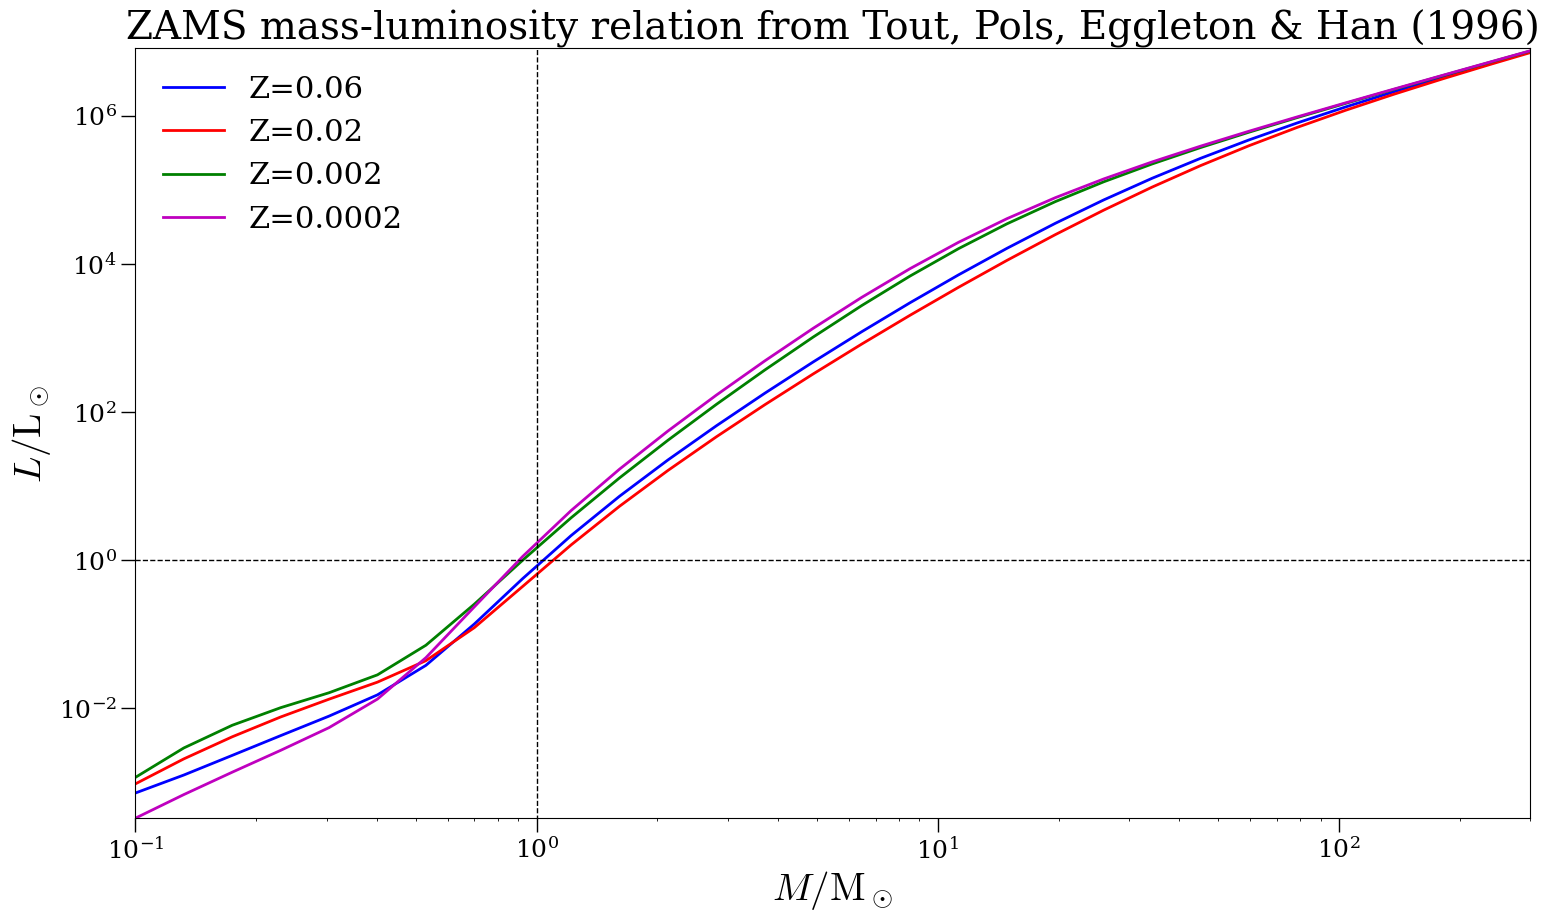

In [14]:
fig, ax = plt.subplots(figsize=(18,10))

ax.plot(test_masses, test_luminosities_z006, 'b', label='Z=0.06')
ax.plot(test_masses, test_luminosities_z002, 'r', label='Z=0.02')
ax.plot(test_masses, test_luminosities_z0002, 'g', label='Z=0.002')
ax.plot(test_masses, test_luminosities_z00002, 'm', label='Z=0.0002')
ax.set_xscale('log')
ax.set_yscale('log')
ax.vlines(1, 1e-4, 1e7, color='k', ls='--', lw=1)
ax.hlines(1, 0.1, 300, color='k', ls='--', lw=1)
ax.set_ylim(min(test_luminosities_z00002), max(test_luminosities_z00002))
ax.set_xlim(0.1, 300)

ax.legend(frameon=False)
ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
ax.set_ylabel('$L/\\mathrm{L}_\\odot$')

ax.set_title('ZAMS mass-luminosity relation from Tout, Pols, Eggleton & Han (1996)')

Finally, we define functions for the surface gravity,

$$\log g = \log \left( \frac{1}{\mathrm{cm}\,\mathrm{s}^{-1}} \frac{GM}{R^2} \right),$$

In [15]:
def log_g(m, metallicity=Z_SUN):
    m = fix_unit(m, MASS_U)
    mrr = ToutMassRadiusRelation(metallicity)
    r = mrr.radius(m)
    g = (ct.G * m / r**2).to(u.cm / u.s**2)
    log_g = np.log10(g.value)
    return log_g


and the effective temperature,

$$T_\mathrm{eff} = \left(\frac{1}{4\pi\sigma_\mathrm{SB}} \frac{L}{R^2} \right)^{\frac{1}{4}},$$

In [16]:
def t_eff(m, metallicity=Z_SUN):
    m = fix_unit(m, MASS_U)
    mrr = ToutMassRadiusRelation(metallicity)
    r = mrr.radius(m)
    mlr = ToutMassLuminosityRelation(metallicity)
    l = mlr.luminosity(m)
    t_eff = l / (4*np.pi*r**2 * ct.sigma_sb)
    t_eff = t_eff**(1/4)
    return t_eff.to(TEMP_U)

### Binary geometry

Next, we define the Roche lobe-equivalent radii, and the L2-equivalent radius.

For the Roche lobe, we adopt the approximation by Eggleton (1983) for the primary Roche lobe-equivalent radius,

$$
R_\mathrm{RL,1} = \frac{0.49 q^{2/3}}{0.6 q^{2/3} + \ln (1+q^{1/3})} A.
$$

Which is implemented in the two functions below for the primary and secondary Roche lobe radii ($R_\mathrm{RL,2}$).

In [17]:
def eggleton_rl1_radius(a, q):
    a = fix_unit(a, SMA_U)
    rl1 = 0.49 * q**(2/3) / (0.6*q**(2/3) + np.log(1 + q**(1/3))) * a
    rl1 = rl1.to(RADIUS_U)
    return rl1    

In [18]:
def eggleton_rl2_radius(a, q):
    a = fix_unit(a, SMA_U)
    Q = 1/q
    rl2 = 0.49 * Q**(2/3) / (0.6*Q**(2/3) + np.log(1 + Q**(1/3))) * a
    rl2 = rl2.to(RADIUS_U)
    return rl2    

For the L2-equivalent radius ($R_\mathrm{L2,2}$), we adopt the fit from Marchant et al. (2016) (equation 2 therein),

$$\frac{R_{L2,2}-R_\mathrm{RL,2}}{R_\mathrm{RL,2}} = 0.299 \arctan \left( 1.84 q^{0.397} \right),$$

which was found to be satisfied in their simulations with an error smaller than 2% within $0.02\leq q\leq1$. This fit is implemented in the function below.

In [19]:
def marchant_l2_radius(a, q):
    a = fix_unit(a, SMA_U)
    rl2 = eggleton_rl2_radius(a, q)
    relative_l2_radius = 0.299 * np.arctan(1.84 * q**0.397)
    l2_radius = (1 + relative_l2_radius) * rl2
    return l2_radius

In [20]:
min_m = 10
max_m = 300
res = 30
test_masses = np.logspace(np.log10(min_m), np.log10(max_m), res)

test_qs = np.array([1, 0.9, 0.8])
test_ps = np.array([1, 2, 3, 4]) * u.d

r_rl1_arr = np.zeros((test_qs.shape[0], test_ps.shape[0], test_masses.shape[0]))
r_rl2_arr = np.zeros((test_qs.shape[0], test_ps.shape[0], test_masses.shape[0]))
r_l2_arr = np.zeros((test_qs.shape[0], test_ps.shape[0], test_masses.shape[0]))

for row, q in enumerate(test_qs):
    for col, p in enumerate(test_ps):
        r_rl1_arr[row, col] = np.array([eggleton_rl1_radius(a_from_p(p, m, q), q).to(u.Rsun).value for m in test_masses])
        r_rl2_arr[row, col] = np.array([eggleton_rl2_radius(a_from_p(p, m, q), q).to(u.Rsun).value for m in test_masses])
        r_l2_arr[row, col] = np.array([marchant_l2_radius(a_from_p(p, m, q), q).to(u.Rsun).value for m in test_masses])


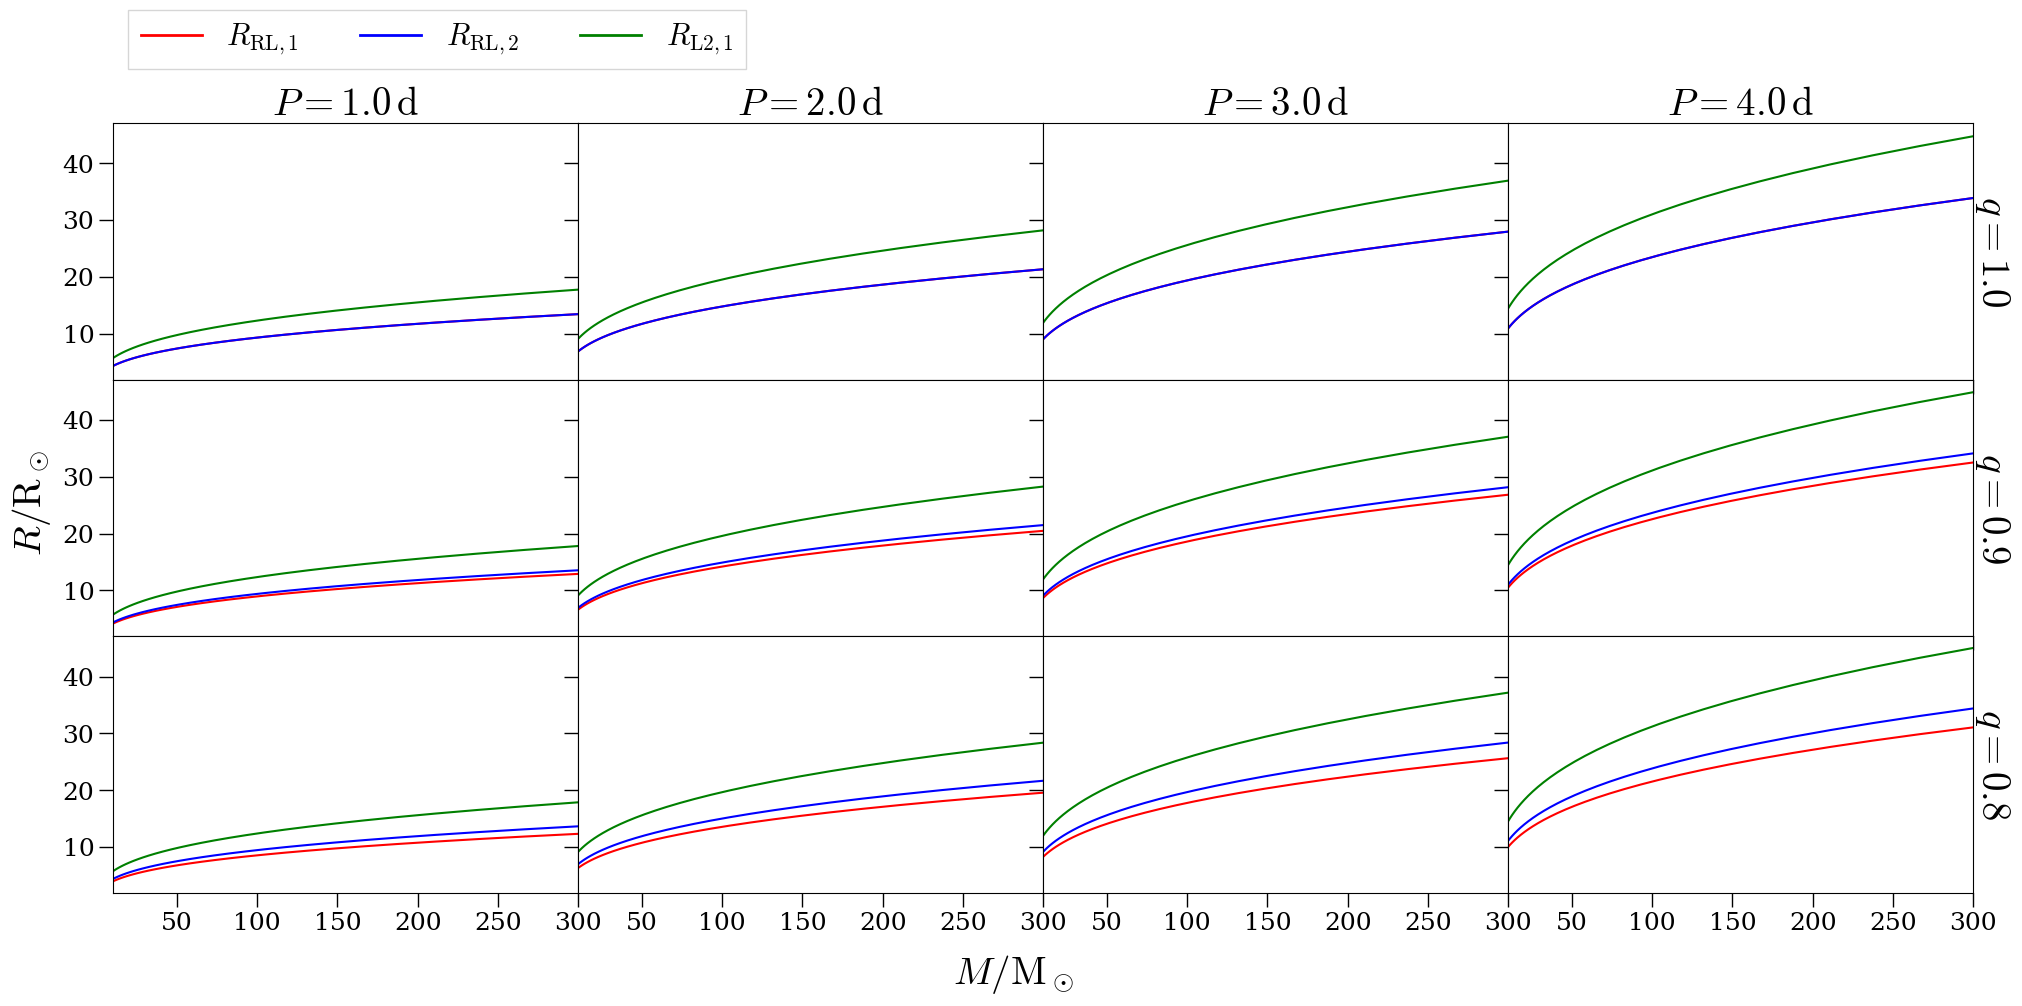

In [21]:
lw = 1.5

fig, axes = plt.subplots(len(test_qs), len(test_ps), figsize=(24, 10), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)

for row, (ax_row, q) in enumerate(zip(axes, test_qs)):
    for col, (ax, p) in enumerate(zip(ax_row, test_ps)):
        ax.plot(test_masses, r_rl1_arr[row, col], 'r-', lw=lw)
        ax.plot(test_masses, r_rl2_arr[row, col], 'b-', lw=lw)
        ax.plot(test_masses, r_l2_arr[row, col], 'g-', lw=lw)

# LIMITS
axes[0, 0].set_xlim(min_m, max_m)

# LABELS
fig.text(0.5, 0.05, r'$M/\mathrm{M}_\odot$', ha='center', va='top', transform=fig.transFigure)
fig.text(0.1, 0.5, r'$R/\mathrm{R}_\odot$', rotation=90, ha='right', va='center', transform=fig.transFigure)

for ax, q in zip(axes[:,-1], test_qs):
    ax.text(1, 0.5, f'$q={q:.1f}$', rotation=-90, ha='left', va='center', transform=ax.transAxes)

for ax, p in zip(axes[0,:], test_ps):
    ax.text(0.5, 1, f'$P={p.value:.1f}\\,\\mathrm{{d}}$', ha='center', va='bottom', transform=ax.transAxes)

handles = []
handles.append(Line2D((0, 0), (0, 0), color='r', ls='-', label=r'$R_\mathrm{RL,1}$'))
handles.append(Line2D((0, 0), (0, 0), color='b', ls='-', label=r'$R_\mathrm{RL,2}$'))
handles.append(Line2D((0, 0), (0, 0), color='g', ls='-', label=r'$R_\mathrm{L2,1}$'))
axes[0, 0].legend(handles=handles, fancybox=False, loc='lower left', bbox_to_anchor=(0, 1.15), ncol=3)

### Timescales

Next we define the relevant timescales for BBH merger formation through CHE.

We take the hydrogen fraction (for the MS timescale) from a linear fit between Big Bang mass fractions (X=0.75, Y=0.05, Z=0) and solar (X=0.7, Y=0.28, Z=0.02).

In [22]:
# TODO: check this assumption
def get_x_y(z):
    x = 0.75 - 5/2 * z
    y = 1 - x - z
    return x, y 

We make a simple estimate of the MS timescale from the luminosity and the amount of hydrogen available in the core at ZAMS,

$$\tau_\mathrm{MS} \approx f_\mathrm{core} X \Delta_{\mathrm{4H}\to\mathrm{He4}}\frac{Mc^2}{L}\approx4.9\times10^{-5}\frac{Mc^2}{L},$$

where we take $f_\mathrm{core}=0.1$ as the fraction of mass in the core, $X$ is the hydrogen mass fraction and $\Delta_{\mathrm{4H}\to\mathrm{He4}}\approx0.007$ is the mass defect of $\mathrm{He}_4$ (i.e., ignore neutrino losses). The function below computes $\tau_\mathrm{MS}$.

In [23]:
def tau_ms(m, metallicity=Z_SUN):
    m = fix_unit(m, MASS_U)
    mlr = ToutMassLuminosityRelation(metallicity)
    l = mlr.luminosity(m)
    x, _ = get_x_y(metallicity)
    f_core = 0.1
    delta_4h_he4 = 0.007
    t_ms = f_core * x * delta_4h_he4 * m * ct.c**2 / l
    return t_ms.to(AGE_U)

The function below computes the thermal timescale, $\tau_\mathrm{KH}$.

In [24]:
def tau_kh(m, metallicity=Z_SUN):
    m = fix_unit(m, MASS_U)
    mrr = ToutMassRadiusRelation(metallicity)
    r = mrr.radius(m)
    mlr = ToutMassLuminosityRelation(metallicity)
    l = mlr.luminosity(m)
    tau_kh = ct.G * m**2 / (2*r*l)   
    return tau_kh.to(AGE_U)
    

For the mixing (Eddington-Sweet) timescale, we adopt equation 11.79 from Maeder (2009),

$$t_\mathrm{ES}\approx t_\mathrm{KH} \frac{GM}{\Omega^2 R^3},$$

used in the function below, for arbitrary $\Omega$.

In [25]:
def tau_es(m, omega, metallicity=Z_SUN):
    m = fix_unit(m, MASS_U)
    _tau_kh = tau_kh(m, metallicity)
    mrr = ToutMassRadiusRelation(metallicity)
    r = mrr.radius(m)
    tau_es = _tau_kh * ct.G * m / (omega**2 * r**3)   
    return tau_es.to(AGE_U)
    

The gravitational decay timescale, assuming a circular orbit, is

$$\tau_\mathrm{GW} = \frac{5}{256} \frac{c^5}{G^3} \frac{A}{(1+q)qM},$$

which is implemented in the function below.

In [26]:
def tau_gw(m, p, q):
    m = fix_unit(m, MASS_U)
    p = fix_unit(p, PERIOD_U)
    a = a_from_p(p, m, q)

    _c = 5 * ct.c**5 / 256 / ct.G**3
    tgw = _c * a**4 / (m**3 * q *(1+q))
    return tgw.to(AGE_U)

We apply $\tau_\mathrm{GW}$ at ZAMS. Because the stars will lose mass and the orbit will widen, $\tau_\mathrm{GW}$ at ZAMS can be used as the *shortest* timescale on which the binary will merge.

Text(0.5, 1.0, 'P=2.0 d, q=1, tidally locked')

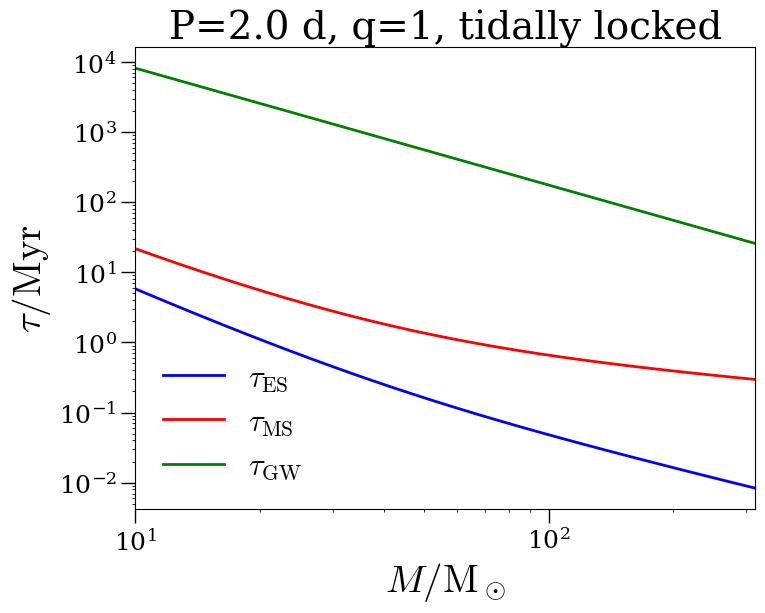

In [27]:
test_p = 2*u.d
test_omega = 2*np.pi/test_p
test_q = 1
test_masses = np.logspace(1, 2.5, 30)
test_tau_es = np.array([tau_es(m, test_omega).to(u.Myr).value for m in test_masses])
test_tau_ms = np.array([tau_ms(m).to(u.Myr).value for m in test_masses])
test_tau_gw = np.array([tau_gw(m, test_p, test_q).to(u.Myr).value for m in test_masses])

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(test_masses, test_tau_es, 'b', label=r'$\tau_\mathrm{ES}$')
ax.plot(test_masses, test_tau_ms, 'r', label=r'$\tau_\mathrm{MS}$')
ax.plot(test_masses, test_tau_gw, 'g', label=r'$\tau_\mathrm{GW}$')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(r'$\tau/\mathrm{Myr}$')
ax.set_xlabel(r'$M/\mathrm{M}_\odot$')
ax.set_xlim(10, 10**2.5)
ax.legend(frameon=False)
ax.set_title(f'P={test_p}, q={test_q}, tidally locked')

### Wind mass loss

For wind mass loss rates, we adopt the thin wind prescription by Gormaz-Matamala et al. (2022), which was implemented in Romagnolo, Gormaz-Matamal & Belczynski (2024) for $T_\mathrm{eff}\geq10\,\mathrm{kK}$ and $\log g \geq3$ stars with thin winds.

Side comment: Romagnolo+24 define optically wind thicks as those with $X_\mathrm{surf}<0.3$ or $\Gamma_\mathrm{e}>0.5$. Does the thin wind surface hydrogen criteria hold for CHE binaries all the way through the MS? Below is figure 5 from de Mink+09, which shows the evolution of the helium surface mass fraction for the primary in a 50+25 binary under SMC metallicity.

![fig4demink09.png](fig4demink09.png)

In this case we could say the thin winds assumption *just* holds, but $\tau_\mathrm{ES}\propto M^3R^{-4}L^{-2}$

In this prescription the mass loss rate is

$$
\begin{align}
\log\dot{M} = &-40.314 + 15.438w + 45.838x - 8.284wx \\
              &+1.0564y - wy/2.36 - 1.1967xy \\
              &+ z \left( 1 + \frac{15.75}{M/\mathrm{M}_\odot} \right),
\end{align}
$$

where   

$$
\begin{align}
w = &\log\frac{T_\mathrm{eff}}{\mathrm{kK}}, \qquad
x = &\frac{1}{\log g}, \qquad
y = &\frac{R}{\mathrm{R}_\odot}, \qquad
z = &\frac{Z}{\mathrm{Z}_\odot}.
\end{align}
$$

The prescription is implemented in the class below, which also implements a spline to speed up calculation.

In [27]:
class GormazMatamalaWinds:

    def __init__(self, metallicity=Z_SUN, m_min=10, m_max=300):
        self.metallicity = metallicity
        self.m_min = m_min
        self.m_max = m_max
        self.mrr = ToutMassRadiusRelation(metallicity)
        self.spline = None
        self._set_spline()

    def _set_spline(self):
        masses = np.logspace(np.log10(self.m_min), np.log10(self.m_max), 30)
        logmdots = np.array([self.log_mass_loss_rate(m) for m in masses])
        self.spline = CubicSpline(masses, logmdots)        

    def log_mass_loss_rate(self, m):
        m = fix_unit(m, MASS_U).to(u.Msun).value
        teff = t_eff(m, self.metallicity)
        logg = log_g(m, self.metallicity)
        r = self.mrr.radius(m)
        
        w = np.log10(teff.to(u.kK).value)
        x = 1/logg
        y = r.to(u.Rsun).value
        z = np.log10(self.metallicity/Z_SUN)

        log_mdot = (-40.314 + 15.438*w + 45.838*x - 8.284*w*x
                    + 1.0564*y - w*y/2.36 - 1.1967*x*y
                    + z * (0.4 + 15.75/m))
        
        return log_mdot

In [1]:
winds = GormazMatamalaWinds()

NameError: name 'GormazMatamalaWinds' is not defined

In [29]:
test_masses = np.logspace(1, 2.5, 30)
test_logmdots = np.array([winds.log_mass_loss_rate(m) for m in test_masses])
test_spline_logmdots = np.array([winds.spline(m) for m in test_masses])

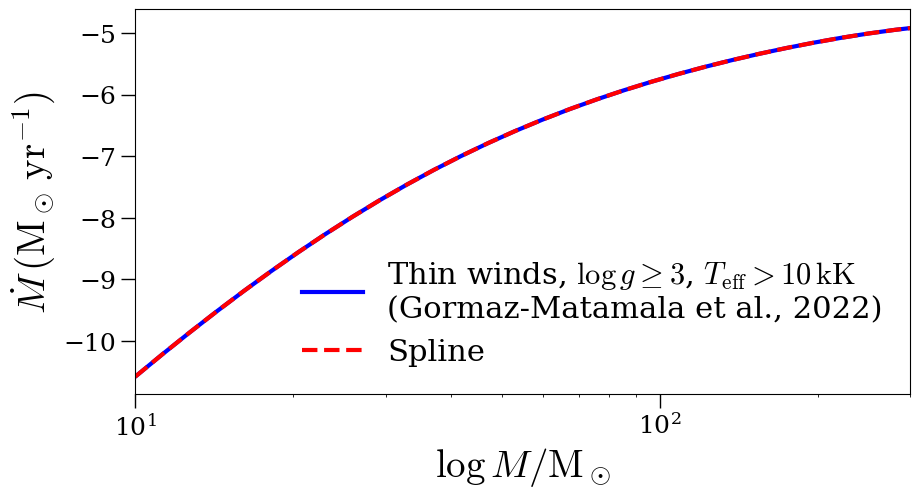

In [30]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(test_masses, test_logmdots, 'b-', lw=3, label='Thin winds, $\\log g\\geq3$, $T_\\mathrm{eff}>10\\,\\mathrm{kK}$ \n(Gormaz-Matamala et al., 2022)')
plt.plot(test_masses, test_spline_logmdots, 'r--', lw=3, label='Spline')
plt.xscale('log')
plt.xlim(10, 300)
plt.xlabel('$\\log M/\\mathrm{M}_\\odot$')
plt.ylabel('$\\dot{M}\\,(\\mathrm{M}_\\odot\,\\mathrm{yr}^{-1})$')
plt.legend(frameon=False)

We assume isotropic winds that carry the specific angular momentum of star (Jeans mode). In this case, semi-major axis evolution is given by

$$\frac{\mathrm{d}A}{A} = - \frac{2}{1+q} \frac{\mathrm{d}M}{M}.$$

To avoid integration, one option is to set the mass loss rate throughout the MS to the one at ZAMS.

In [31]:
m_zams = 10
logmdot = winds.spline(m_zams)
tms = tau_ms(m_zams).to(u.Myr).value
print(' '.join((f'For {m_zams:.0f} Mo,',
              f'log Mdot = {logmdot:.1f} (Mo yr-1),',
              f'and log t_ms = {tms:.2f} Myr.',
              f'A fixed mass loss rate would imply on a total mass loss of {10**(logmdot + np.log10(tms*1e6))}')))

For 10 Mo, log Mdot = -10.6 (Mo yr-1), and log t_ms = 21.68 Myr. A fixed mass loss rate would imply on a total mass loss of 0.0005722629323267468


In [32]:
m_zams = 100
logmdot = winds.spline(m_zams)
tms = tau_ms(m_zams).to(u.Myr).value
print(' '.join((f'For {m_zams:.0f} Mo,',
              f'log Mdot = {logmdot:.1f} (Mo yr-1),',
              f'and log t_ms = {tms:.2f} Myr.',
              f'A fixed mass loss rate would imply on a total mass loss of {10**(logmdot + np.log10(tms*1e6))}')))

For 100 Mo, log Mdot = -5.7 (Mo yr-1), and log t_ms = 0.66 Myr. A fixed mass loss rate would imply on a total mass loss of 1.168740600082111


For a fixed mass loss rate, in Jeans mode mass loss,

$$\ln \left(
     \frac{A(t)}{A_\mathrm{ZAMS}}
     \right) = -2\ln\left(
     1 - \frac{1}{1+q_\mathrm{ZAMS}} \frac{\dot{M}}{M_\mathrm{ZAMS}}t.
     \right)$$



We then set $A_\mathrm{TAMS}=A(\tau_\mathrm{MS})$ and use the equation above to find $A_\mathrm{TAMS}$. $A_\mathrm{TAMS}$ and $P_\mathrm{ZAMS}$ are calculated in the two functions below.

In [33]:
def a_tams(m_zams, a_zams, q_zams, metallicity=Z_SUN, f_wind=1):
    m_zams = fix_unit(m_zams, MASS_U)
    a_zams = fix_unit(a_zams, SMA_U)
    wind = GormazMatamalaWinds(metallicity)
    mdot_zams = f_wind * 10**wind.spline(m_zams) * u.Msun / u.yr
    t_ms = tau_ms(m_zams)
    antilog = 1 - 1/(1+q_zams) * mdot_zams/m_zams * t_ms
    ln_a_tams = np.log(a_zams.to(SMA_U).value) - 2 * np.log(antilog)
    a_tams = np.exp(ln_a_tams) * SMA_U
    return a_tams


In  $P_\mathrm{TAMS}$ we use the mass and mass ratio at TAMS to recover the orbital period.

In [34]:
def p_tams(m_zams, p_zams, q_zams, metallicity=Z_SUN, f_wind=1):
    m_zams = fix_unit(m_zams, MASS_U)
    p_zams = fix_unit(p_zams, PERIOD_U)
    a_zams = a_from_p(p_zams, m_zams, q_zams)

    wind = GormazMatamalaWinds(metallicity)
    mdot_zams = f_wind * 10**wind.spline(m_zams) * u.Msun / u.yr
    t_ms = tau_ms(m_zams)

    m_tams = m_zams - mdot_zams*t_ms
    q_tams = m_zams/m_tams * q_zams

    antilog = 1 - 1/(1+q_zams) * mdot_zams/m_zams * t_ms

    ln_a_tams = np.log(a_zams.to(SMA_U).value) - 2 * np.log(antilog)
    a_tams = np.exp(ln_a_tams) * SMA_U

    p_tams = p_from_a(a_tams, m_tams, q_tams)
    return m_tams, p_tams, q_tams


Playing around with different ZAMS settings, we find that the original wind prescription leads to very little orbital widening from ZAMS to TAMS. We thus introduce a paramter $f_\mathrm{wind}$ which multiplies the mass loss rate to check the wind intensity needed to "close off" the CHE window.

In [35]:
f_wind = 1
m_zams = 50
q_zams = 1
p_zams = 2 * u.d
a_zams = a_from_p(p_zams, m_zams, q_zams)
print(f'For f_wind={f_wind}, m_zams={m_zams}, q_zams={q_zams}, p_zams={p_zams}')
print(f'A_ZAMS={a_zams}, A_TAMS={a_tams(m_zams, a_zams, q_zams, f_wind=f_wind)}')
print(f'P_ZAMS={p_zams}, P_TAMS={p_tams(m_zams, p_zams, q_zams, f_wind=f_wind)[1]}')

For f_wind=1, m_zams=50, q_zams=1, p_zams=2.0 d
A_ZAMS=31.00685996216504 solRad, A_TAMS=31.181603386988744 solRad
P_ZAMS=2.0 d, P_TAMS=2.019766397479431 d


In [36]:
f_wind = 10
m_zams = 50
q_zams = 1
p_zams = 2 * u.d
a_zams = a_from_p(p_zams, m_zams, q_zams)
print(f'For f_wind={f_wind}, m_zams={m_zams}, q_zams={q_zams}, p_zams={p_zams}')
print(f'A_ZAMS={a_zams}, A_TAMS={a_tams(m_zams, a_zams, q_zams, f_wind=f_wind)}')
print(f'P_ZAMS={p_zams}, P_TAMS={p_tams(m_zams, p_zams, q_zams, f_wind=f_wind)[1]}')

For f_wind=10, m_zams=50, q_zams=1, p_zams=2.0 d
A_ZAMS=31.00685996216504 solRad, A_TAMS=32.82302149096455 solRad
P_ZAMS=2.0 d, P_TAMS=2.2094864467202635 d


In [37]:
f_wind = 50
m_zams = 50
q_zams = 1
p_zams = 2 * u.d
a_zams = a_from_p(p_zams, m_zams, q_zams)
print(f'For f_wind={f_wind}, m_zams={m_zams}, q_zams={q_zams}, p_zams={p_zams}')
print(f'A_ZAMS={a_zams}, A_TAMS={a_tams(m_zams, a_zams, q_zams, f_wind=f_wind)}')
print(f'P_ZAMS={p_zams}, P_TAMS={p_tams(m_zams, p_zams, q_zams, f_wind=f_wind)[1]}')

For f_wind=50, m_zams=50, q_zams=1, p_zams=2.0 d


A_ZAMS=31.00685996216504 solRad, A_TAMS=41.95291386164414 solRad
P_ZAMS=2.0 d, P_TAMS=3.394787505454439 d


## Constraints

Let's bring it all together! For now the equations are solved numerically, but these can be written analytically as well (probably, I haven't checked yet).

In [38]:
m_min = 1
m_max = 300
res = 30
test_masses = np.logspace(np.log10(m_min), np.log10(m_max), res)
test_q = 1.
test_z = Z_SUN

In [39]:
mrr = ToutMassRadiusRelation(test_z)
mlr = ToutMassLuminosityRelation(test_z)
wind = GormazMatamalaWinds(test_z)

From RLOF we get a minimum separation per mass.

In [40]:
rlof_test_ps = np.zeros(test_masses.shape)

for i, m in enumerate(test_masses):
    def f_to_min(p): return np.abs(mrr.radius(m).value - eggleton_rl1_radius(a_from_p(p, m, test_q), test_q).value)
    rlof_test_ps[i] = fmin(f_to_min, x0=1, disp=False)

/tmp/ipykernel_1565064/3149354998.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rlof_test_ps[i] = fmin(f_to_min, x0=1, disp=False)


For L2OF we get a minimum separation per mass.

In [41]:
l2of_test_ps = np.zeros(test_masses.shape)

for i, m in enumerate(test_masses):
    def f_to_min(p): return np.abs(mrr.radius(m).value - marchant_l2_radius(a_from_p(p, m, test_q), test_q).value)
    l2of_test_ps[i] = fmin(f_to_min, x0=1, disp=False)

/tmp/ipykernel_1565064/2684303067.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  l2of_test_ps[i] = fmin(f_to_min, x0=1, disp=False)


From $\tau_\mathrm{ES}^\mathrm{TAMS}=\tau_\mathrm{MS}$ we get a maximum separation for the system to be considered to be chemically homogeneously evolving at ZAMS.

In [42]:
t_es_test_ps = np.zeros(test_masses.shape)

for i, m in enumerate(test_masses):
    def f_to_min(p): return np.abs(tau_ms(m, test_z).value - tau_es(m, 2*np.pi/(p*u.d), test_z).value)
    t_es_test_ps[i] = fmin(f_to_min, x0=1, disp=False)

/tmp/ipykernel_1565064/2247500868.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t_es_test_ps[i] = fmin(f_to_min, x0=1, disp=False)


With the widening due to winds, we find $\tau_\mathrm{ES}$ at TAMS, and check if the system is still CHE at that point, i.e., we solve, $\tau_\mathrm{ES}^\mathrm{TAMS}=\tau_\mathrm{MS}$. Systems between this period and the one found from $\tau_\mathrm{ES}^\mathrm{ZAMS}=\tau_\mathrm{MS}$ start as CHE binaries, but leave the CHE track before reaching TAMS.

In [43]:
f_wind = 1
f1_wind_test_ps = np.zeros(test_masses.shape)

for i, m in enumerate(test_masses):
    def f_to_min(p): 
        mtams, ptams, qtams = p_tams(m, p, test_q, metallicity=test_z, f_wind=f_wind)
        return np.abs(tau_ms(m, test_z).value - tau_es(mtams, 2*np.pi/ptams, test_z).value)
    f1_wind_test_ps[i] = fmin(f_to_min, x0=1, disp=False)

/tmp/ipykernel_1565064/630594199.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f1_wind_test_ps[i] = fmin(f_to_min, x0=1, disp=False)


Let's also look at other values of $f_\mathrm{wind}$.

In [44]:
f_wind = 10
f10_wind_test_ps = np.zeros(test_masses.shape)

for i, m in enumerate(test_masses):
    def f_to_min(p): 
        mtams, ptams, qtams = p_tams(m, p, test_q, metallicity=test_z, f_wind=f_wind)
        return np.abs(tau_ms(m, test_z).value - tau_es(mtams, 2*np.pi/ptams, test_z).value)
    f10_wind_test_ps[i] = fmin(f_to_min, x0=1, disp=False)

/tmp/ipykernel_1565064/42194769.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f10_wind_test_ps[i] = fmin(f_to_min, x0=1, disp=False)


In [45]:
f_wind = 25
f50_wind_test_ps = np.zeros(test_masses.shape)

for i, m in enumerate(test_masses):
    def f_to_min(p): 
        mtams, ptams, qtams = p_tams(m, p, test_q, metallicity=test_z, f_wind=f_wind)
        return np.abs(tau_ms(m, test_z).value - tau_es(mtams, 2*np.pi/ptams, test_z).value)
    f50_wind_test_ps[i] = fmin(f_to_min, x0=1, disp=False)

/tmp/ipykernel_1565064/2425423097.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f50_wind_test_ps[i] = fmin(f_to_min, x0=1, disp=False)


Finally, we also add $\tau_\mathrm{GW}$. As written above, this is the shortest timescale on which the binary should merge.

In [46]:
t_gw_test_ps = np.zeros(test_masses.shape)

for i, m in enumerate(test_masses):
    def f_to_min(p): return np.abs(tau_gw(m, p, test_q).value - t_H.value)
    t_gw_test_ps[i] = fmin(f_to_min, x0=1, disp=False)

/tmp/ipykernel_1565064/1483777283.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t_gw_test_ps[i] = fmin(f_to_min, x0=1, disp=False)


Now we look at all of them together. Lower limits are plotted as dashed lines, and upper limits as solid lines.

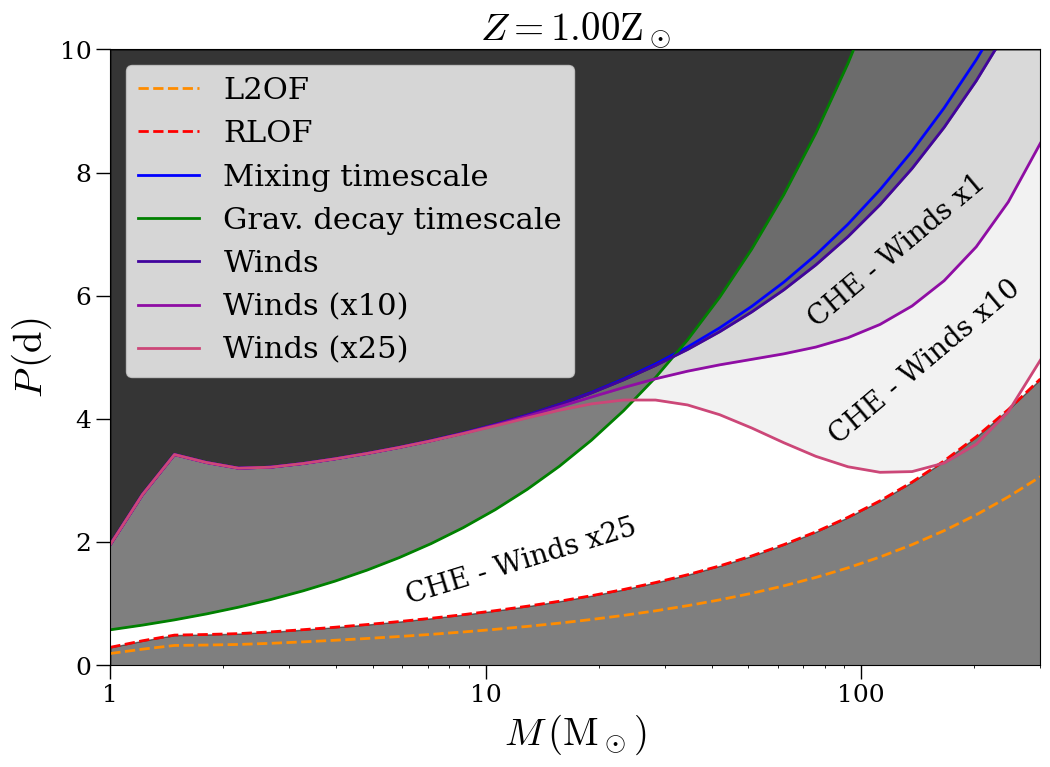

In [47]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(test_masses, l2of_test_ps, '--', color='darkorange', label='L2OF', lw=2)
ax.plot(test_masses, rlof_test_ps, '--', color='red', label='RLOF', lw=2)

ax.plot(test_masses, t_es_test_ps, 'b-', label='Mixing timescale', lw=2)
ax.plot(test_masses, t_gw_test_ps, 'g-', label='Grav. decay timescale', lw=2)

ax.plot(test_masses, f1_wind_test_ps, '-', color=cm.plasma(0.1), label='Winds', lw=2)
ax.plot(test_masses, f10_wind_test_ps, '-', color=cm.plasma(0.3), label='Winds (x10)', lw=2)
ax.plot(test_masses, f50_wind_test_ps, '-', color=cm.plasma(0.5), label='Winds (x25)', lw=2)


ax.fill_between(test_masses, t_gw_test_ps, np.tile(10, test_masses.shape), color='k', alpha=0.5)
ax.fill_between(test_masses, np.tile(0, test_masses.shape), rlof_test_ps, color='k', alpha=0.5)
ax.fill_between(test_masses, f1_wind_test_ps, np.tile(10, test_masses.shape), color='k', alpha=0.5)
ax.fill_between(test_masses, f10_wind_test_ps, np.tile(10, test_masses.shape), color='k', alpha=0.1)
ax.fill_between(test_masses, f50_wind_test_ps, np.tile(10, test_masses.shape), color='k', alpha=0.05)

ax.text(6, 1, 'CHE - Winds x25', rotation=17, fontsize=20)
ax.text(80, 3.6, 'CHE - Winds x10', rotation=40, fontsize=20)
ax.text(70, 5.5, 'CHE - Winds x1', rotation=40, fontsize=20)


ax.set_xscale('log')
ax.set_xticks([1, 10, 100])
ax.set_xticklabels([1, 10, 100])

ax.set_xlim(m_min, m_max)
ax.set_ylim(0, 10)

ax.set_ylabel('$P\\,(\\mathrm{d})$')
ax.set_xlabel('$M\\,(\\mathrm{M}_\\odot)$')

ax.set_title(f'$Z={test_z/Z_SUN:.2f}\mathrm{{Z}}_\odot$')

ax.legend()

Dark grey regions are always outside of the CHE window. The white region is inside the CHE window up to winds x50 stronger than the original GM22 prescription. The two light gray regions indicate area that is added to the CHE window when winds are weakend to x10 the GM22 prescription, and when they are kept to the original prescription (x1).

#### The same as above, but for $3Z_\odot$

In [48]:
m_min = 1
m_max = 300
res = 30
test_masses = np.logspace(np.log10(m_min), np.log10(m_max), res)
test_q = 1.
test_z = 3*Z_SUN

In [49]:
mrr = ToutMassRadiusRelation(test_z)
mlr = ToutMassLuminosityRelation(test_z)
wind = GormazMatamalaWinds(test_z)

In [50]:
rlof_test_ps = np.zeros(test_masses.shape)

for i, m in enumerate(test_masses):
    def f_to_min(p): return np.abs(mrr.radius(m).value - eggleton_rl1_radius(a_from_p(p, m, test_q), test_q).value)
    rlof_test_ps[i] = fmin(f_to_min, x0=1, disp=False)

/tmp/ipykernel_1565064/3149354998.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rlof_test_ps[i] = fmin(f_to_min, x0=1, disp=False)


In [51]:
l2of_test_ps = np.zeros(test_masses.shape)

for i, m in enumerate(test_masses):
    def f_to_min(p): return np.abs(mrr.radius(m).value - marchant_l2_radius(a_from_p(p, m, test_q), test_q).value)
    l2of_test_ps[i] = fmin(f_to_min, x0=1, disp=False)

/tmp/ipykernel_1565064/2684303067.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  l2of_test_ps[i] = fmin(f_to_min, x0=1, disp=False)


In [52]:
t_es_test_ps = np.zeros(test_masses.shape)

for i, m in enumerate(test_masses):
    def f_to_min(p): return np.abs(tau_ms(m, test_z).value - tau_es(m, 2*np.pi/(p*u.d), test_z).value)
    t_es_test_ps[i] = fmin(f_to_min, x0=1, disp=False)

/tmp/ipykernel_1565064/2247500868.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t_es_test_ps[i] = fmin(f_to_min, x0=1, disp=False)


In [53]:
f_wind = 1
f1_wind_test_ps = np.zeros(test_masses.shape)

for i, m in enumerate(test_masses):
    def f_to_min(p): 
        mtams, ptams, qtams = p_tams(m, p, test_q, metallicity=test_z, f_wind=f_wind)
        return np.abs(tau_ms(m, test_z).value - tau_es(mtams, 2*np.pi/ptams, test_z).value)
    f1_wind_test_ps[i] = fmin(f_to_min, x0=1, disp=False)

/tmp/ipykernel_1565064/630594199.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f1_wind_test_ps[i] = fmin(f_to_min, x0=1, disp=False)


In [54]:
f_wind = 10
f10_wind_test_ps = np.zeros(test_masses.shape)

for i, m in enumerate(test_masses):
    def f_to_min(p): 
        mtams, ptams, qtams = p_tams(m, p, test_q, metallicity=test_z, f_wind=f_wind)
        return np.abs(tau_ms(m, test_z).value - tau_es(mtams, 2*np.pi/ptams, test_z).value)
    f10_wind_test_ps[i] = fmin(f_to_min, x0=1, disp=False)

/tmp/ipykernel_1565064/42194769.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f10_wind_test_ps[i] = fmin(f_to_min, x0=1, disp=False)


In [55]:
f_wind = 25
f50_wind_test_ps = np.zeros(test_masses.shape)

for i, m in enumerate(test_masses):
    def f_to_min(p): 
        mtams, ptams, qtams = p_tams(m, p, test_q, metallicity=test_z, f_wind=f_wind)
        return np.abs(tau_ms(m, test_z).value - tau_es(mtams, 2*np.pi/ptams, test_z).value)
    f50_wind_test_ps[i] = fmin(f_to_min, x0=1, disp=False)

/tmp/ipykernel_1565064/2425423097.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f50_wind_test_ps[i] = fmin(f_to_min, x0=1, disp=False)


In [56]:
t_gw_test_ps = np.zeros(test_masses.shape)

for i, m in enumerate(test_masses):
    def f_to_min(p): return np.abs(tau_gw(m, p, test_q).value - t_H.value)
    t_gw_test_ps[i] = fmin(f_to_min, x0=1, disp=False)

/tmp/ipykernel_1565064/1483777283.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t_gw_test_ps[i] = fmin(f_to_min, x0=1, disp=False)


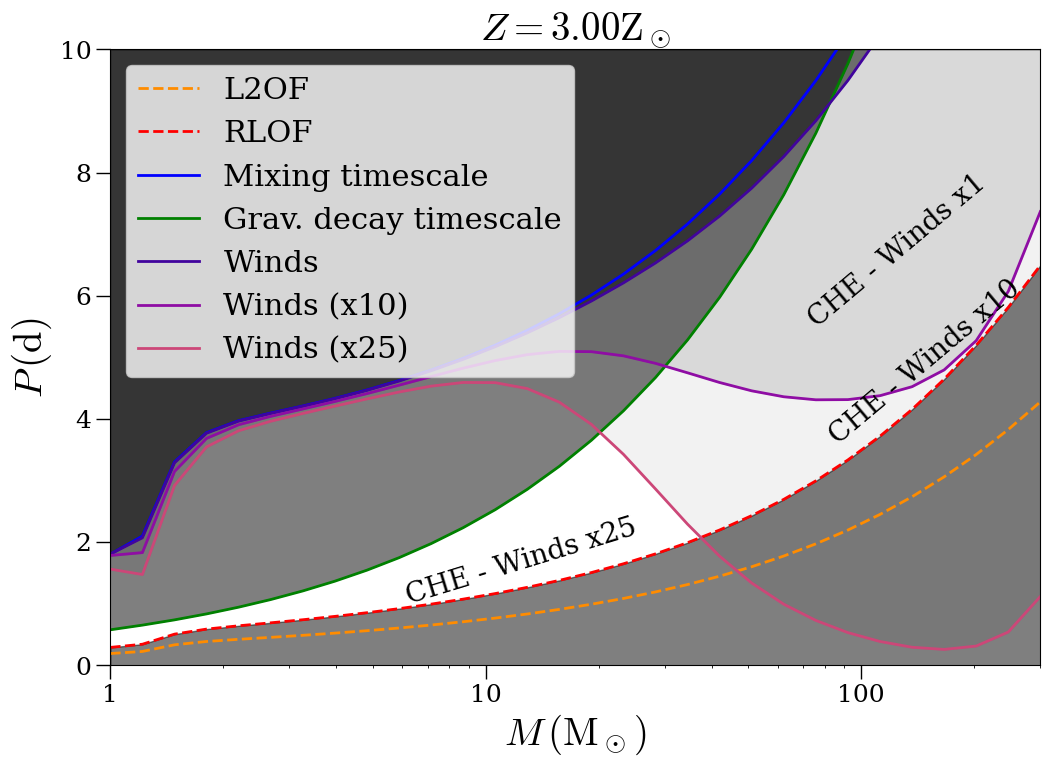

In [57]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(test_masses, l2of_test_ps, '--', color='darkorange', label='L2OF', lw=2)
ax.plot(test_masses, rlof_test_ps, '--', color='red', label='RLOF', lw=2)

ax.plot(test_masses, t_es_test_ps, 'b-', label='Mixing timescale', lw=2)
ax.plot(test_masses, t_gw_test_ps, 'g-', label='Grav. decay timescale', lw=2)

ax.plot(test_masses, f1_wind_test_ps, '-', color=cm.plasma(0.1), label='Winds', lw=2)
ax.plot(test_masses, f10_wind_test_ps, '-', color=cm.plasma(0.3), label='Winds (x10)', lw=2)
ax.plot(test_masses, f50_wind_test_ps, '-', color=cm.plasma(0.5), label='Winds (x25)', lw=2)


ax.fill_between(test_masses, t_gw_test_ps, np.tile(10, test_masses.shape), color='k', alpha=0.5)
ax.fill_between(test_masses, np.tile(0, test_masses.shape), rlof_test_ps, color='k', alpha=0.5)
ax.fill_between(test_masses, f1_wind_test_ps, np.tile(10, test_masses.shape), color='k', alpha=0.5)
ax.fill_between(test_masses, f10_wind_test_ps, np.tile(10, test_masses.shape), color='k', alpha=0.1)
ax.fill_between(test_masses, f50_wind_test_ps, np.tile(10, test_masses.shape), color='k', alpha=0.05)

ax.text(6, 1, 'CHE - Winds x25', rotation=17, fontsize=20)
ax.text(80, 3.6, 'CHE - Winds x10', rotation=40, fontsize=20)
ax.text(70, 5.5, 'CHE - Winds x1', rotation=40, fontsize=20)


ax.set_xscale('log')
ax.set_xticks([1, 10, 100])
ax.set_xticklabels([1, 10, 100])

ax.set_xlim(m_min, m_max)
ax.set_ylim(0, 10)

ax.set_ylabel('$P\\,(\\mathrm{d})$')
ax.set_xlabel('$M\\,(\\mathrm{M}_\\odot)$')

ax.set_title(f'$Z={test_z/Z_SUN:.2f}\mathrm{{Z}}_\odot$')

ax.legend()

#### The same as above, but for $0.1Z_\odot$

In [58]:
m_min = 1
m_max = 300
res = 30
test_masses = np.logspace(np.log10(m_min), np.log10(m_max), res)
test_q = 1.
test_z = 0.1*Z_SUN

In [59]:
mrr = ToutMassRadiusRelation(test_z)
mlr = ToutMassLuminosityRelation(test_z)
wind = GormazMatamalaWinds(test_z)

In [60]:
rlof_test_ps = np.zeros(test_masses.shape)

for i, m in enumerate(test_masses):
    def f_to_min(p): return np.abs(mrr.radius(m).value - eggleton_rl1_radius(a_from_p(p, m, test_q), test_q).value)
    rlof_test_ps[i] = fmin(f_to_min, x0=1, disp=False)

/tmp/ipykernel_1565064/3149354998.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rlof_test_ps[i] = fmin(f_to_min, x0=1, disp=False)


In [61]:
l2of_test_ps = np.zeros(test_masses.shape)

for i, m in enumerate(test_masses):
    def f_to_min(p): return np.abs(mrr.radius(m).value - marchant_l2_radius(a_from_p(p, m, test_q), test_q).value)
    l2of_test_ps[i] = fmin(f_to_min, x0=1, disp=False)

/tmp/ipykernel_1565064/2684303067.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  l2of_test_ps[i] = fmin(f_to_min, x0=1, disp=False)


In [62]:
t_es_test_ps = np.zeros(test_masses.shape)

for i, m in enumerate(test_masses):
    def f_to_min(p): return np.abs(tau_ms(m, test_z).value - tau_es(m, 2*np.pi/(p*u.d), test_z).value)
    t_es_test_ps[i] = fmin(f_to_min, x0=1, disp=False)

/tmp/ipykernel_1565064/2247500868.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t_es_test_ps[i] = fmin(f_to_min, x0=1, disp=False)


In [63]:
f_wind = 1
f1_wind_test_ps = np.zeros(test_masses.shape)

for i, m in enumerate(test_masses):
    def f_to_min(p): 
        mtams, ptams, qtams = p_tams(m, p, test_q, metallicity=test_z, f_wind=f_wind)
        return np.abs(tau_ms(m, test_z).value - tau_es(mtams, 2*np.pi/ptams, test_z).value)
    f1_wind_test_ps[i] = fmin(f_to_min, x0=1, disp=False)

/tmp/ipykernel_1565064/630594199.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f1_wind_test_ps[i] = fmin(f_to_min, x0=1, disp=False)


In [64]:
f_wind = 10
f10_wind_test_ps = np.zeros(test_masses.shape)

for i, m in enumerate(test_masses):
    def f_to_min(p): 
        mtams, ptams, qtams = p_tams(m, p, test_q, metallicity=test_z, f_wind=f_wind)
        return np.abs(tau_ms(m, test_z).value - tau_es(mtams, 2*np.pi/ptams, test_z).value)
    f10_wind_test_ps[i] = fmin(f_to_min, x0=1, disp=False)

/tmp/ipykernel_1565064/42194769.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f10_wind_test_ps[i] = fmin(f_to_min, x0=1, disp=False)


In [65]:
f_wind = 25
f50_wind_test_ps = np.zeros(test_masses.shape)

for i, m in enumerate(test_masses):
    def f_to_min(p): 
        mtams, ptams, qtams = p_tams(m, p, test_q, metallicity=test_z, f_wind=f_wind)
        return np.abs(tau_ms(m, test_z).value - tau_es(mtams, 2*np.pi/ptams, test_z).value)
    f50_wind_test_ps[i] = fmin(f_to_min, x0=1, disp=False)

/tmp/ipykernel_1565064/2425423097.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f50_wind_test_ps[i] = fmin(f_to_min, x0=1, disp=False)


In [66]:
t_gw_test_ps = np.zeros(test_masses.shape)

for i, m in enumerate(test_masses):
    def f_to_min(p): return np.abs(tau_gw(m, p, test_q).value - t_H.value)
    t_gw_test_ps[i] = fmin(f_to_min, x0=1, disp=False)

/tmp/ipykernel_1565064/1483777283.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t_gw_test_ps[i] = fmin(f_to_min, x0=1, disp=False)


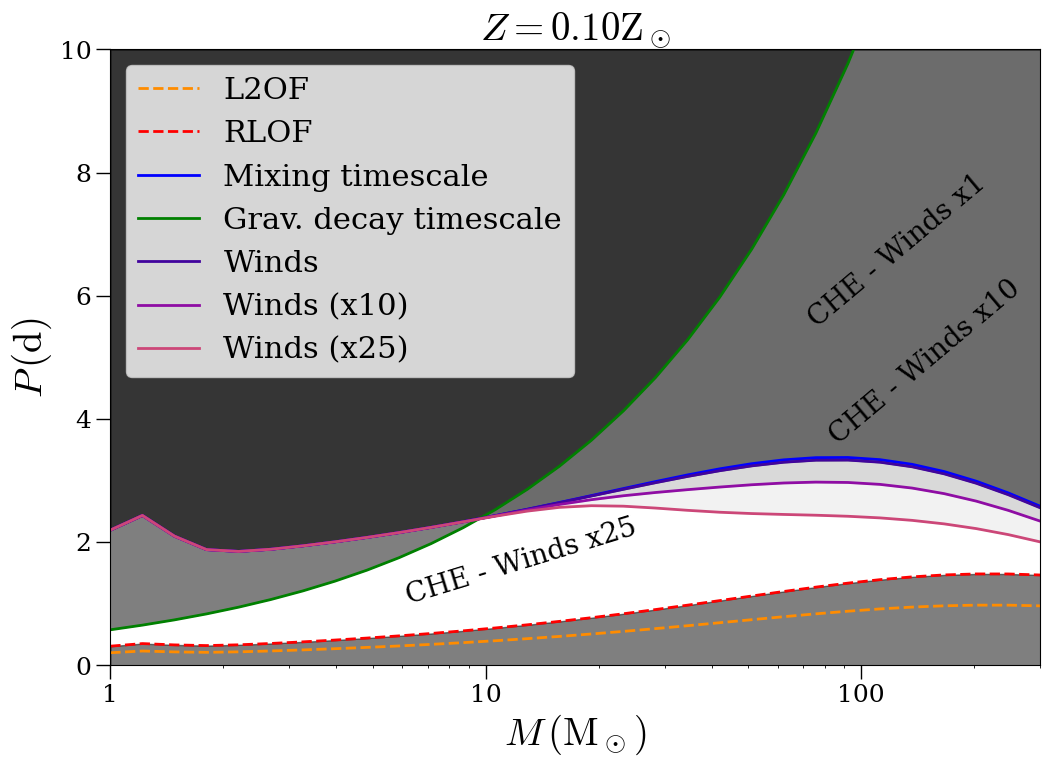

In [67]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(test_masses, l2of_test_ps, '--', color='darkorange', label='L2OF', lw=2)
ax.plot(test_masses, rlof_test_ps, '--', color='red', label='RLOF', lw=2)

ax.plot(test_masses, t_es_test_ps, 'b-', label='Mixing timescale', lw=2)
ax.plot(test_masses, t_gw_test_ps, 'g-', label='Grav. decay timescale', lw=2)

ax.plot(test_masses, f1_wind_test_ps, '-', color=cm.plasma(0.1), label='Winds', lw=2)
ax.plot(test_masses, f10_wind_test_ps, '-', color=cm.plasma(0.3), label='Winds (x10)', lw=2)
ax.plot(test_masses, f50_wind_test_ps, '-', color=cm.plasma(0.5), label='Winds (x25)', lw=2)


ax.fill_between(test_masses, t_gw_test_ps, np.tile(10, test_masses.shape), color='k', alpha=0.5)
ax.fill_between(test_masses, np.tile(0, test_masses.shape), rlof_test_ps, color='k', alpha=0.5)
ax.fill_between(test_masses, f1_wind_test_ps, np.tile(10, test_masses.shape), color='k', alpha=0.5)
ax.fill_between(test_masses, f10_wind_test_ps, np.tile(10, test_masses.shape), color='k', alpha=0.1)
ax.fill_between(test_masses, f50_wind_test_ps, np.tile(10, test_masses.shape), color='k', alpha=0.05)

ax.text(6, 1, 'CHE - Winds x25', rotation=17, fontsize=20)
ax.text(80, 3.6, 'CHE - Winds x10', rotation=40, fontsize=20)
ax.text(70, 5.5, 'CHE - Winds x1', rotation=40, fontsize=20)


ax.set_xscale('log')
ax.set_xticks([1, 10, 100])
ax.set_xticklabels([1, 10, 100])

ax.set_xlim(m_min, m_max)
ax.set_ylim(0, 10)

ax.set_ylabel('$P\\,(\\mathrm{d})$')
ax.set_xlabel('$M\\,(\\mathrm{M}_\\odot)$')

ax.set_title(f'$Z={test_z/Z_SUN:.2f}\mathrm{{Z}}_\odot$')

ax.legend()

# Just figures

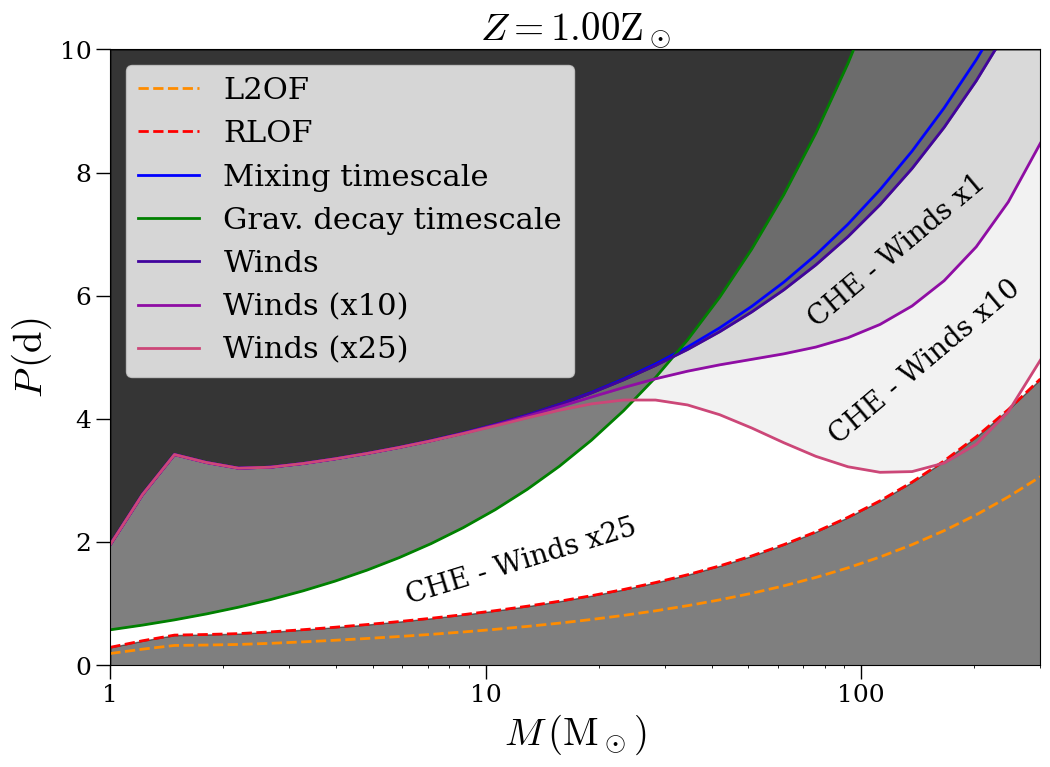

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(test_masses, l2of_test_ps, '--', color='darkorange', label='L2OF', lw=2)
ax.plot(test_masses, rlof_test_ps, '--', color='red', label='RLOF', lw=2)

ax.plot(test_masses, t_es_test_ps, 'b-', label='Mixing timescale', lw=2)
ax.plot(test_masses, t_gw_test_ps, 'g-', label='Grav. decay timescale', lw=2)

ax.plot(test_masses, f1_wind_test_ps, '-', color=cm.plasma(0.1), label='Winds', lw=2)
ax.plot(test_masses, f10_wind_test_ps, '-', color=cm.plasma(0.3), label='Winds (x10)', lw=2)
ax.plot(test_masses, f50_wind_test_ps, '-', color=cm.plasma(0.5), label='Winds (x25)', lw=2)


ax.fill_between(test_masses, t_gw_test_ps, np.tile(10, test_masses.shape), color='k', alpha=0.5)
ax.fill_between(test_masses, np.tile(0, test_masses.shape), rlof_test_ps, color='k', alpha=0.5)
ax.fill_between(test_masses, f1_wind_test_ps, np.tile(10, test_masses.shape), color='k', alpha=0.5)
ax.fill_between(test_masses, f10_wind_test_ps, np.tile(10, test_masses.shape), color='k', alpha=0.1)
ax.fill_between(test_masses, f50_wind_test_ps, np.tile(10, test_masses.shape), color='k', alpha=0.05)

ax.text(6, 1, 'CHE - Winds x25', rotation=17, fontsize=20)
ax.text(80, 3.6, 'CHE - Winds x10', rotation=40, fontsize=20)
ax.text(70, 5.5, 'CHE - Winds x1', rotation=40, fontsize=20)


ax.set_xscale('log')
ax.set_xticks([1, 10, 100])
ax.set_xticklabels([1, 10, 100])

ax.set_xlim(m_min, m_max)
ax.set_ylim(0, 10)

ax.set_ylabel('$P\\,(\\mathrm{d})$')
ax.set_xlabel('$M\\,(\\mathrm{M}_\\odot)$')

ax.set_title(f'$Z={test_z/Z_SUN:.2f}\mathrm{{Z}}_\odot$')

ax.legend()

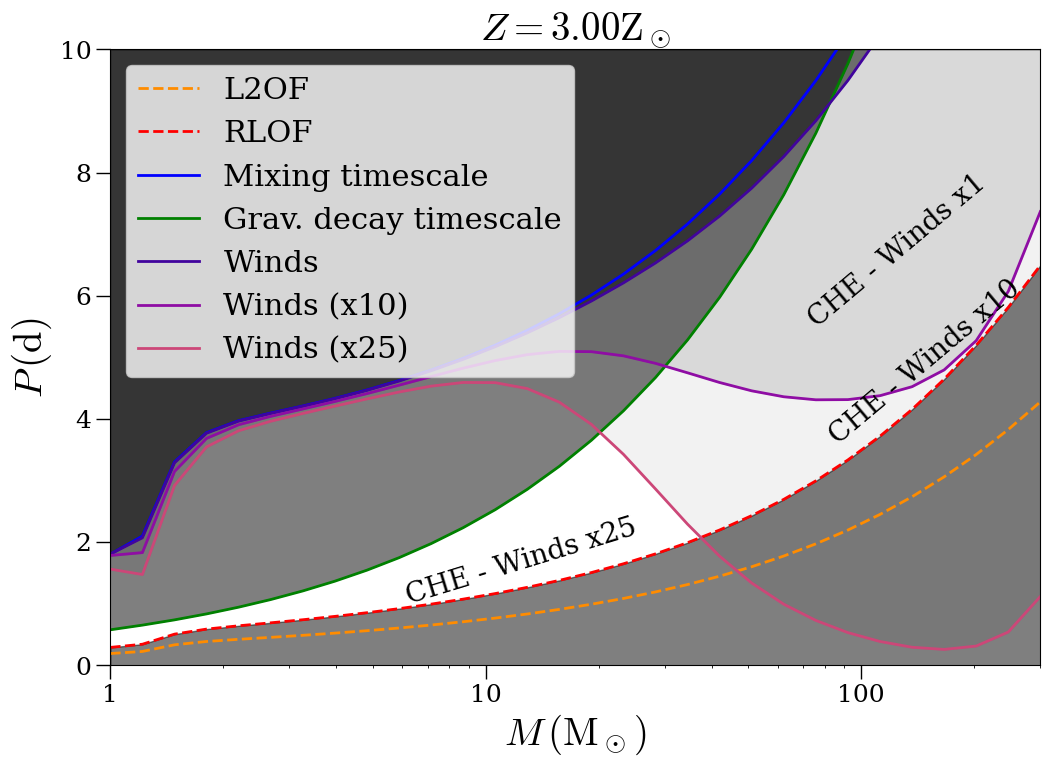

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(test_masses, l2of_test_ps, '--', color='darkorange', label='L2OF', lw=2)
ax.plot(test_masses, rlof_test_ps, '--', color='red', label='RLOF', lw=2)

ax.plot(test_masses, t_es_test_ps, 'b-', label='Mixing timescale', lw=2)
ax.plot(test_masses, t_gw_test_ps, 'g-', label='Grav. decay timescale', lw=2)

ax.plot(test_masses, f1_wind_test_ps, '-', color=cm.plasma(0.1), label='Winds', lw=2)
ax.plot(test_masses, f10_wind_test_ps, '-', color=cm.plasma(0.3), label='Winds (x10)', lw=2)
ax.plot(test_masses, f50_wind_test_ps, '-', color=cm.plasma(0.5), label='Winds (x25)', lw=2)


ax.fill_between(test_masses, t_gw_test_ps, np.tile(10, test_masses.shape), color='k', alpha=0.5)
ax.fill_between(test_masses, np.tile(0, test_masses.shape), rlof_test_ps, color='k', alpha=0.5)
ax.fill_between(test_masses, f1_wind_test_ps, np.tile(10, test_masses.shape), color='k', alpha=0.5)
ax.fill_between(test_masses, f10_wind_test_ps, np.tile(10, test_masses.shape), color='k', alpha=0.1)
ax.fill_between(test_masses, f50_wind_test_ps, np.tile(10, test_masses.shape), color='k', alpha=0.05)

ax.text(6, 1, 'CHE - Winds x25', rotation=17, fontsize=20)
ax.text(80, 3.6, 'CHE - Winds x10', rotation=40, fontsize=20)
ax.text(70, 5.5, 'CHE - Winds x1', rotation=40, fontsize=20)


ax.set_xscale('log')
ax.set_xticks([1, 10, 100])
ax.set_xticklabels([1, 10, 100])

ax.set_xlim(m_min, m_max)
ax.set_ylim(0, 10)

ax.set_ylabel('$P\\,(\\mathrm{d})$')
ax.set_xlabel('$M\\,(\\mathrm{M}_\\odot)$')

ax.set_title(f'$Z={test_z/Z_SUN:.2f}\mathrm{{Z}}_\odot$')

ax.legend()

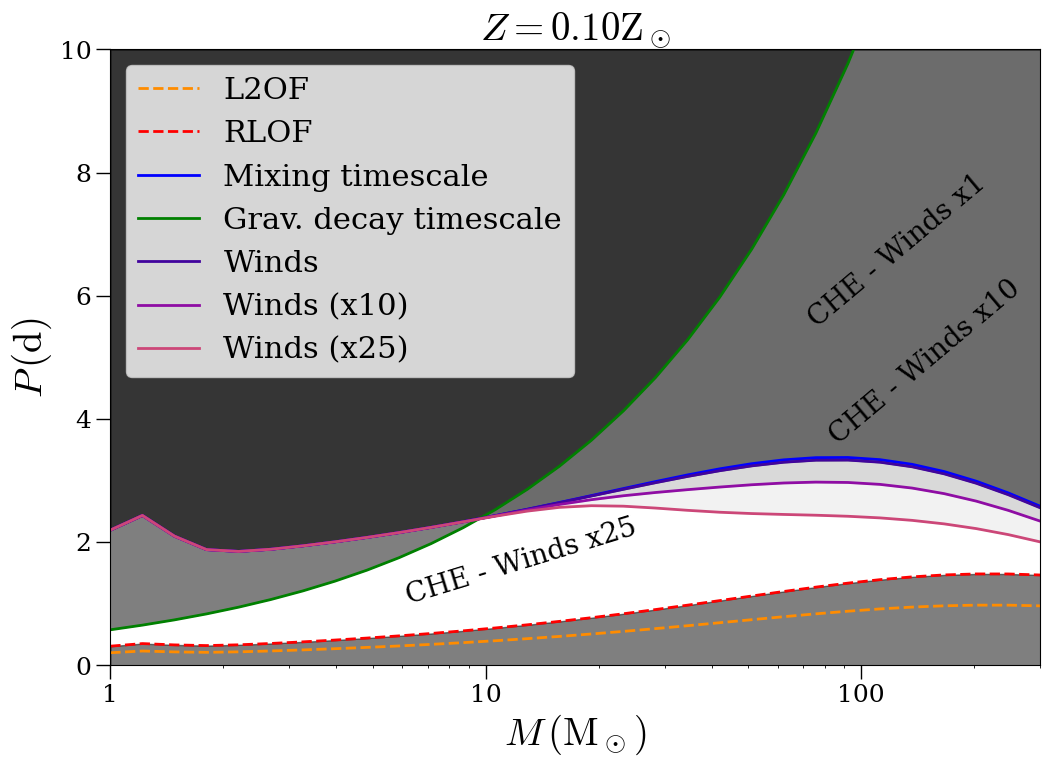

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(test_masses, l2of_test_ps, '--', color='darkorange', label='L2OF', lw=2)
ax.plot(test_masses, rlof_test_ps, '--', color='red', label='RLOF', lw=2)

ax.plot(test_masses, t_es_test_ps, 'b-', label='Mixing timescale', lw=2)
ax.plot(test_masses, t_gw_test_ps, 'g-', label='Grav. decay timescale', lw=2)

ax.plot(test_masses, f1_wind_test_ps, '-', color=cm.plasma(0.1), label='Winds', lw=2)
ax.plot(test_masses, f10_wind_test_ps, '-', color=cm.plasma(0.3), label='Winds (x10)', lw=2)
ax.plot(test_masses, f50_wind_test_ps, '-', color=cm.plasma(0.5), label='Winds (x25)', lw=2)


ax.fill_between(test_masses, t_gw_test_ps, np.tile(10, test_masses.shape), color='k', alpha=0.5)
ax.fill_between(test_masses, np.tile(0, test_masses.shape), rlof_test_ps, color='k', alpha=0.5)
ax.fill_between(test_masses, f1_wind_test_ps, np.tile(10, test_masses.shape), color='k', alpha=0.5)
ax.fill_between(test_masses, f10_wind_test_ps, np.tile(10, test_masses.shape), color='k', alpha=0.1)
ax.fill_between(test_masses, f50_wind_test_ps, np.tile(10, test_masses.shape), color='k', alpha=0.05)

ax.text(6, 1, 'CHE - Winds x25', rotation=17, fontsize=20)
ax.text(80, 3.6, 'CHE - Winds x10', rotation=40, fontsize=20)
ax.text(70, 5.5, 'CHE - Winds x1', rotation=40, fontsize=20)


ax.set_xscale('log')
ax.set_xticks([1, 10, 100])
ax.set_xticklabels([1, 10, 100])

ax.set_xlim(m_min, m_max)
ax.set_ylim(0, 10)

ax.set_ylabel('$P\\,(\\mathrm{d})$')
ax.set_xlabel('$M\\,(\\mathrm{M}_\\odot)$')

ax.set_title(f'$Z={test_z/Z_SUN:.2f}\mathrm{{Z}}_\odot$')

ax.legend()